In [ ]:
#In this section of notebook we will impliment the augmentations code to the CSV files to make 5 columns:
# We need a class, ymin,ymax,xmin,xmax for the locations of the polyLine

In [194]:
# import the libraries
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


In [195]:
#show the paths to where the images annotations is located

images_path = Path('/Volumes/easy\ store/Sorghum_Images/Images')
anno_path = Path('/Volumes/easy\ store/Sorghum_Images/Image_Annotations')

In [196]:
print(images_path,"\n",anno_path)

/Volumes/easy\ store/Sorghum_Images/Images 
 /Volumes/easy\ store/Sorghum_Images/Image_Annotations


In [197]:
print(os.getcwd())

os.chdir('/Volumes/easy store/Sorghum_Images/Image_Annotations/')
print(os.getcwd())

/Volumes/easy store/Sorghum_Images/Image_Annotations
/Volumes/easy store/Sorghum_Images/Image_Annotations


In [198]:
# In this section we will develop a dataframe that will parse the CSV file in the image annotations file
# This file is broken up into 5 columns but we only care about 3 of them, One of which needs to be dealt with
# with some regex

anno_file = pd.read_csv('/Volumes/easy store/Sorghum_Images/Image_Annotations/annotations_2.csv')  




In [199]:
anno_file

,filename,file_size,X_shape,Y_shape,labels
0,Snap-615.jpg,3718989,"[1228,1283,1323,1421,1484,1513,1676,1708,1786,...","[501,609,700,870,987,1014,999,1003,1067,1159,1...",hypha
1,Snap-615.jpg,3718989,"[1050,1132,1223,1290,1372,1428,1490,1546,1608,...","[620,738,881,967,1067,1150,1199,1206,1181,1174...",hypha
2,Snap-615.jpg,3718989,"[2237,2342,2426,2516,2558,2558,2373,2322,2267,...","[1493,1568,1650,1690,1719,1652,1553,1508,1470,...",hypha
3,Snap-615.jpg,3718989,"[1077,1119,1143,1125,1126,1087,1043,1014,970,9...","[878,932,890,868,821,801,738,692,696,761,825,872]",hypha
4,Snap-615.jpg,3718989,"[1108,1121,1094,1070,1045,1016,1027,1059,1088,...","[1057,1032,997,952,923,919,967,1008,1054,1059]",hypha
...,...,...,...,...,...
703,Snap-374.jpg,3268278,"[259,308,324,317,280,220,124,100,56,14,0,0,44,...","[749,761,723,679,668,625,469,439,439,443,444,5...",arbuscule
704,Snap-374.jpg,3268278,"[765,751,821,786,787,742,710,675,635,618,621,6...","[1536,1584,1711,1750,1764,1696,1610,1566,1549,...",hypha
705,Snap-374.jpg,3268278,"[695,766,803,849,903,957,997,1001,1013,905,838...","[567,625,649,605,521,478,385,311,255,185,164,1...",arbuscule
706,Snap-375.jpg,3704299,"[14,143,345,443,430,465,500,544,593,628,644,61...","[1585,1564,1535,1510,1452,1426,1386,1368,1372,...",hypha


In [200]:
import ast
xmax_list =[]
xmin_list =[]
ymax_list =[]
ymin_list =[]
for line in anno_file["X_shape"]:
    # interpret as a list 
    line = ast.literal_eval(line)
    #print(line)
    if len(line) ==0:
        Xmax = "NA"
        Xmin = "NA"
    else:
        Xmax = max(line)
        Xmin = min(line)
    
    xmax_list.append(Xmax)
    xmin_list.append(Xmin)

for line in anno_file["Y_shape"]:
    # interpret as a list 
    line = ast.literal_eval(line)
    #print(line)
    if len(line) ==0:
        Ymax = "NA"
        Ymin = "NA"
    else:
        Ymax = max(line)
        Ymin = min(line)
    
    ymax_list.append(Ymax)
    ymin_list.append(Ymin)
    
# assign the values in the list to rows in the dataframe, return the dataframe

anno_file["x_max"] = xmax_list
anno_file["x_min"] = xmin_list
anno_file["y_max"] = ymax_list
anno_file["y_min"] = ymin_list
df = anno_file.dropna()



In [201]:
df

,filename,file_size,X_shape,Y_shape,labels,x_max,x_min,y_max,y_min
0,Snap-615.jpg,3718989,"[1228,1283,1323,1421,1484,1513,1676,1708,1786,...","[501,609,700,870,987,1014,999,1003,1067,1159,1...",hypha,2556,1157,1621,465
1,Snap-615.jpg,3718989,"[1050,1132,1223,1290,1372,1428,1490,1546,1608,...","[620,738,881,967,1067,1150,1199,1206,1181,1174...",hypha,2560,1050,1920,616
2,Snap-615.jpg,3718989,"[2237,2342,2426,2516,2558,2558,2373,2322,2267,...","[1493,1568,1650,1690,1719,1652,1553,1508,1470,...",hypha,2558,2231,1719,1470
3,Snap-615.jpg,3718989,"[1077,1119,1143,1125,1126,1087,1043,1014,970,9...","[878,932,890,868,821,801,738,692,696,761,825,872]",hypha,1143,970,932,692
4,Snap-615.jpg,3718989,"[1108,1121,1094,1070,1045,1016,1027,1059,1088,...","[1057,1032,997,952,923,919,967,1008,1054,1059]",hypha,1121,1016,1059,919
...,...,...,...,...,...,...,...,...,...
702,Snap-389.jpg,3550638,"[1482,1556,1585,1571,1529,1522,1515,1503,1456,...","[779,833,905,1011,1076,1146,1213,1256,1262,125...",hypha,1706,1304,1326,558
703,Snap-374.jpg,3268278,"[259,308,324,317,280,220,124,100,56,14,0,0,44,...","[749,761,723,679,668,625,469,439,439,443,444,5...",arbuscule,324,0,761,439
704,Snap-374.jpg,3268278,"[765,751,821,786,787,742,710,675,635,618,621,6...","[1536,1584,1711,1750,1764,1696,1610,1566,1549,...",hypha,996,618,1918,1536
705,Snap-374.jpg,3268278,"[695,766,803,849,903,957,997,1001,1013,905,838...","[567,625,649,605,521,478,385,311,255,185,164,1...",arbuscule,1013,646,649,164


In [202]:
df.labels.unique()

array(['hypha', 'coil', 'arbuscule', 'non-amf(fungus)'], dtype=object)

In [203]:
class_dict = {'hypha': 0, 'coil': 1, 'arbuscule': 2, 'non-amf(fungus)': 3}
df['labels'] = df['labels'].apply(lambda x:  class_dict[x])
df= df.drop(columns=['X_shape', 'Y_shape'])

<ipython-input-203-7284314d4979>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['labels'].apply(lambda x:  class_dict[x])


In [225]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

Image Dimension    :  (1920, 2560, 3)
Image Height       :  1920
Image Width        :  2560
Number of Channels :  3


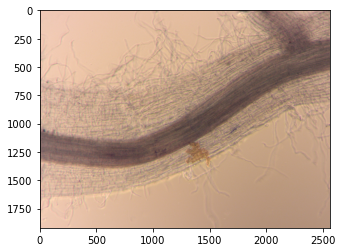

In [230]:
os.chdir("/Volumes/easy store/Sorghum_Images/Images")
import cv2
import matplotlib.pyplot as plt
img = read_image('Snap-209.jpg')

plt.imshow(img)

 
# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)


In [237]:
# okay so we still need to get the dimensions from the data set and we need to make 
# sure we add that to our annotations file

width_list = []
height_list =[]
for image in df["filename"]:
    img = read_image(str(image))
    dimensions = img.shape
    height = img.shape[0]
    width = img.shape[1]
    height_list.append(height)
    width_list.append(width)

df['width'] = width_list
df['height'] = height_list
    
    


In [238]:
df

,filename,file_size,labels,x_max,x_min,y_max,y_min,width,height
0,Snap-615.jpg,3718989,0,2556,1157,1621,465,2560,1920
1,Snap-615.jpg,3718989,0,2560,1050,1920,616,2560,1920
2,Snap-615.jpg,3718989,0,2558,2231,1719,1470,2560,1920
3,Snap-615.jpg,3718989,0,1143,970,932,692,2560,1920
4,Snap-615.jpg,3718989,0,1121,1016,1059,919,2560,1920
...,...,...,...,...,...,...,...,...,...
702,Snap-389.jpg,3550638,0,1706,1304,1326,558,2560,1920
703,Snap-374.jpg,3268278,2,324,0,761,439,2560,1920
704,Snap-374.jpg,3268278,0,996,618,1918,1536,2560,1920
705,Snap-374.jpg,3268278,2,1013,646,649,164,2560,1920
